In [1]:
import ipywidgets as widgets
import xgboost as xgb
import os
from ipywidgets import Box
import pandas as pd
from datetime import datetime, timedelta
import plotly
import plotly.express as px
import matplotlib.pyplot as plt 
import csv
from flask import Flask, send_file, make_response, request
from flask_sqlalchemy import SQLAlchemy
from sqlite3 import Connection as SQLite3Connection
from sort import mergeSort
from sqlalchemy import event
from sqlalchemy.engine import Engine
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance, plot_tree, XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display, HTML


display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

df_bitcoin = pd.read_csv('BTC_USD Bitfinex Historical Data.csv')
df_euro = pd.read_csv('EUR_USD Historical Data.csv')
df_gold = pd.read_csv('Gold Futures Historical Data.csv')
df_nasdaq = pd.read_csv('Nasdaq 100 Futures Historical Data.csv')
df_sp500 = pd.read_csv('S&P 500 Futures Historical Data.csv')
df_vix = pd.read_csv('S&P 500 VIX Futures Historical Data.csv')
df_tsla = pd.read_csv('TSLA Historical Data.csv')

all_dataframes = [df_bitcoin, df_euro, df_gold, df_nasdaq, df_sp500, df_tsla, df_vix]

for i in all_dataframes :
    if i is df_euro or i is df_vix:
        i['Date'] = pd.to_datetime(i['Date']) # convertit la data à un format intéressant
        i['Change %'] = i['Change %'].str.replace('%', '').astype(float)
    else:
        i['Date'] = pd.to_datetime(i['Date']) # convertit la data à un format intéressant
        i['Price'] = i['Price'].str.replace(',', '').astype(float) # on convertit nos données dans des types intéressants
        i['Open'] = i['Open'].str.replace(',', '').astype(float)
        i['High'] = i['High'].str.replace(',', '').astype(float)
        i['Low'] = i['Low'].str.replace(',', '').astype(float)
        i['Change %'] = i['Change %'].str.replace('%', '').astype(float)

In [4]:
class Stack: ##Fichier a part
     def __init__(self):
         self.items = []

     def isEmpty(self):
         return self.items == []

     def push(self, item):
         self.items.append(item)

     def pop(self):
         return self.items.pop()

     def peek(self):
         return self.items[len(self.items)-1]

     def size(self):
         return len(self.items)

In [5]:

app = Flask(__name__)
 
app.config["SQLALCHEMY_DATABASE_URI"] = "sqlite:///sqlitedb.file"
app.config["SQLALCHEMY_TRACK_MODIFICATIONS"] = 0 


@event.listens_for(Engine, "connect")
def _set_sqlite_pragma(dbapi_connection, connection_record):
    if isinstance(dbapi_connection, SQLite3Connection):
        cursor = dbapi_connection.cursor()
        cursor.execute("PRAGMA foreign_keys=ON;")
        cursor.close()


In [6]:
def affgraph(choix, form):
    if (form == 1):
        if choix == 1:
            plt.title("prix du BTC")
            fig = plt.plot(df_bitcoin['Date'], df_bitcoin['Price'])
            plt.rcParams["figure.figsize"] = (30,5)
        elif choix == 2:
            plt.title('Cours de l\'euro')
            fig = plt.plot(df_euro['Date'], df_euro['Price'])
        elif choix == 3:
            plt.title('Cours de l\'or')
            fig = plt.plot(df_gold['Date'], df_gold['Price'])
        elif choix == 4:
            plt.title('Cours de Tesla')
            fig = plt.plot(df_tsla['Date'], df_tsla['Price'])
        elif choix == 5:
            plt.title('Cours du Nasdaq')
            fig = plt.plot(df_nasdaq['Date'], df_nasdaq['Price'])
        elif choix == 6:
            plt.title('Cours du S&P500')
            fig = plt.plot(df_sp500['Date'], df_sp500['Price'])
        elif choix == 7:
            plt.title('Cours du VIX')
            fig = plt.plot(df_vix['Date'], df_vix['Price'])
    else :
        if choix == 1:
            print(df_bitcoin.to_string())
        elif choix == 2:
            print(df_euro.to_string())
        elif choix == 3:
            print(df_gold.to_string())
        elif choix == 4:
            print(df_tsla.to_string())
        elif choix == 5:
            print(df_nasdaq.to_string())
        elif choix == 6:
            print(df_sp500.to_string())
        elif choix == 7:
            print(df_vix.to_string()) 

choix = widgets.ToggleButtons(
    options=[('BTC', 1), ('EUR_USD', 2), ('GOLD', 3),('TSLA',4),('NASDAQ',5),('SP500',6),('VIX',7)],
    description='Select Data:',
    value=1,
    readout=True,
)
form = widgets.Dropdown( options = [('Graph', 1), ('Tableau', 2)], 
    Description='Selectionnez le format',
    value = 1)


out = widgets.interactive_output(affgraph, {'choix': choix, 'form': form})

widgets.VBox([widgets.HBox([choix, form]), out])

In [7]:
def getprice(df, t): # df est le dataframe et t est la date
    if ((df.loc[df['Date']==(t), 'Price']).empty) == True: #ca veut dire qu'on est dans un cas ou il y a rien a cette date
        yesterday = t - timedelta(days=1) # c'est le jour d'avant t
        price = getprice(df,yesterday) # on prend le dernier prix en date de facon recursive
    else : 
        price = df.loc[df['Date']==t, 'Price']
    return float(price)

def computeChange(t,l): # t est la date et l est la liste de nos 7 dataframes
    #on veut le changement sur 5, 10, 20, 30, 90 jours
    if ((l[0]['Date'].max())-t).days < 90 :
        return 'Vous avez choisit une date trop récente pour calculer le changement sur 90 jours'
    if ((l[0]['Date'].min())> t):
        return 'Vous avez choisit une date trop ancienne, il faut prendre une date postérieure au 2 février 2012'
    p = [5,10,20,30,90]
    resul = [] # on a dans chaque liste les changements d'un dataframe
    resul.append(t)
    for i in range(len(l)):
        prixt = getprice(l[i], t) # prix à la date t
        for j in p:
            prixn = getprice(l[i],(t + timedelta(days=j))) # prix à la date t+j
            val = (prixt/prixn)-1 # la valeur qu'on voulait calculer
            resul.append(val)
    return resul

# ça vous retourne les changement dans une liste de listes où on a dans l'ordre de all_dataframes 
#date1 = pd.to_datetime('2021-06-28')
#tes = computeChange(date1, all_dataframes)



In [8]:


ldl = []
for i in df_bitcoin['Date'] :
    ldl.append(computeChange(i,all_dataframes))


# eventuellement voir à afficher ça dans un graph ave des barres
#On va tout mettre dans un dataframe de 36 colonne avec Date-BTC_5-BTC_10 etc...

In [9]:
ldl_test = ldl
del ldl_test[0:90]


In [10]:
lst = ['Date','BTC_5', 'BTC_10', 'BTC_20', 'BTC_30','BTC_90', 'EURO_5', 'EURO_10', 'EURO_20', 'EURO_30','EURO_90', 'GOLD_5', 'GOLD_10', 'GOLD_20', 'GOLD_30', 'GOLD_90','NASDAQ_5','NASDAQ_10','NASDAQ_20','NASDAQ_30','NASDAQ_90','SP500_5','SP500_10','SP500_20','SP500_30','SP500_90','TSLA_5','TSLA_10','TSLA_20','TSLA_30','TSLA_90','VIX_5','VIX_10','VIX_20','VIX_30','VIX_90']
# Create the pandas DataFrame


dataf = pd.DataFrame(ldl_test, columns = lst)
dataf.head()

#on sépare nos données pour l'entrainement  
train = dataf.loc[dataf['Date']<(pd.to_datetime('2020-01-01'))]
test = dataf.loc[dataf['Date']>=(pd.to_datetime('2020-01-01'))]

from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
dataf['Date'] = lbl.fit_transform(dataf['Date'].astype(str))
train['Date'] = lbl.fit_transform(train['Date'].astype(str))
test['Date'] = lbl.fit_transform(test['Date'].astype(str))


X = dataf.drop('BTC_5',axis =1)
y = dataf['BTC_5']
X_train = train.drop('BTC_5',axis =1)
X_test = test.drop('BTC_5',axis = 1)
y_train = train['BTC_5']
y_test = test['BTC_5']



In [11]:
dataf.head()

,Date,BTC_5,BTC_10,BTC_20,BTC_30,BTC_90,EURO_5,EURO_10,EURO_20,EURO_30,...,TSLA_5,TSLA_10,TSLA_20,TSLA_30,TSLA_90,VIX_5,VIX_10,VIX_20,VIX_30,VIX_90
0,3496,0.053722,0.069939,0.130979,0.033896,-0.137862,0.002872,0.004994,0.016002,0.024064,...,-0.027267,-0.005270,-0.025999,-0.055249,-0.331151,-0.046203,-0.129001,-0.187330,-0.183265,-0.321752
1,3495,-0.072747,0.081361,0.201161,0.014266,-0.142155,-0.002612,0.001947,0.009724,0.020959,...,0.000709,-0.002961,-0.007155,-0.053056,-0.358739,-0.001105,-0.123181,-0.228340,-0.177808,-0.296224
2,3494,-0.088965,0.051391,0.096623,0.075907,-0.184770,-0.006312,-0.000593,0.006994,0.019515,...,0.002931,-0.000747,0.007601,-0.051271,-0.352923,0.010858,-0.096993,-0.238757,-0.185833,-0.161261
3,3493,-0.057937,0.013344,-0.004890,0.131333,-0.179974,-0.007322,-0.002537,0.005970,0.017249,...,-0.003626,-0.031728,-0.037631,-0.064507,-0.324432,0.021798,-0.032008,-0.145397,-0.184428,-0.293519
4,3492,-0.024000,0.058844,0.010164,0.188389,-0.110074,-0.007490,-0.001693,0.005800,0.009588,...,-0.029513,-0.055646,-0.062634,-0.084418,-0.341985,0.032698,0.009590,-0.136281,-0.158526,-0.285983


In [12]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [13]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bymax_depth = 5, alpha = 3, n_estimators = 29)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[19:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bymax_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 0.070605


In [14]:
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {preds[:10]}')

y_true = [ 0.05372184 -0.0727466  -0.08896488 -0.05793703 -0.024      -0.00764846
  0.00475186 -0.00689187  0.04214176 -0.0222541 ]
y_pred = [ 0.04615281  0.02850373  0.04276643  0.00234658  0.01109686 -0.00662094
 -0.04262311 -0.04070874 -0.01553599 -0.01815687]


In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [16]:
predicted_prices = X_test
predicted_prices['Close'] = preds

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_bitcoin.Date, y=dataf.BTC_5,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_bitcoin.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_bitcoin.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=df_bitcoin.Date,
                         y=preds,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [17]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

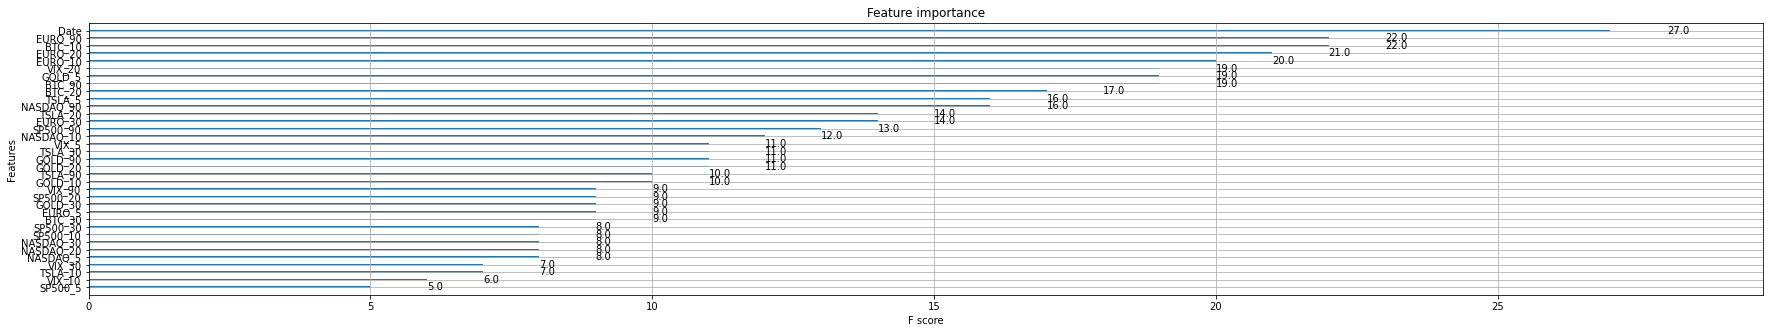

In [18]:
plot_importance(xg_reg)

In [19]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'max_depth': 10, 'alpha': 3}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.368859,0.000104,0.369132,0.000384
1,0.266838,0.000881,0.267410,0.000379
2,0.197262,0.001549,0.198401,0.001091
3,0.152203,0.002265,0.154005,0.001589
4,0.122533,0.002236,0.124974,0.001623


In [20]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.073881
Name: test-rmse-mean, dtype: float64


In [21]:
print((1+preds).cumprod())

[1.04615283e+00 1.07597208e+00 1.12198758e+00 1.12462044e+00
 1.13710022e+00 1.12957156e+00 1.08142567e+00 1.03740215e+00
 1.02128506e+00 1.00274169e+00 9.96872783e-01 9.98397708e-01
 1.00173140e+00 1.03536773e+00 1.01445866e+00 9.57761943e-01
 9.13909435e-01 9.03372049e-01 8.82838309e-01 8.76556277e-01
 8.54541421e-01 8.20542574e-01 7.84036160e-01 7.60843277e-01
 7.54210114e-01 7.44270504e-01 7.56348491e-01 7.33043015e-01
 6.92789674e-01 6.59760773e-01 6.00297332e-01 5.73455095e-01
 5.47813118e-01 5.26856482e-01 5.05860388e-01 4.86988008e-01
 4.64458734e-01 4.40943301e-01 4.17189121e-01 3.96172017e-01
 3.75131458e-01 3.46938610e-01 3.12665224e-01 2.68928736e-01
 2.21755847e-01 1.93279624e-01 1.66681990e-01 1.43586561e-01
 1.30135685e-01 1.20681532e-01 1.13879375e-01 1.09251060e-01
 1.11179873e-01 1.13721304e-01 1.20104022e-01 1.25319153e-01
 1.25839323e-01 1.30258635e-01 1.34670004e-01 1.37610361e-01
 1.40614912e-01 1.43536806e-01 1.40801385e-01 1.34927064e-01
 1.30811960e-01 1.298136

In [22]:
para = widgets.ToggleButtons(
    options=[('learning_rate', 1), ('max_depth', 2), ('Subsample', 3),('colsample_bytre',4),('n_estimators',5)],
    description='Select parameter:',
    value=1,
    readout=True,
)

learning_rate = widgets.FloatSlider(description='learning_rate', value = 0.5, min = 0, max = 1, step = 0.05)
max_depth = widgets.IntSlider(description='max_depth', value = 1) # 10 par defaut
Subsample = widgets.FloatSlider(description='Subsample', value=0.5, min = 0, max = 1, step = 0.05) # dans [0.1]
colsample_bytre = widgets.FloatSlider(description='colsample_bytre', value=0.5, min = 0, max = 1, step = 0.05) # dans [0.1]
n_estimators = widgets.IntSlider(description='n_estimators', value = 1)

def f(learning_rate, max_depth, Subsample, colsample_bytre, n_estimators):
    params = {"objective":"reg:squarederror", 'learning_rate':learning_rate, 'colsample_bytree': colsample_bytre, 'subsample': Subsample, 'max_depth': max_depth, 'alpha': 3, 'n_estimators':n_estimators}
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10)
    print((cv_results["test-rmse-mean"]).tail(1))

out = widgets.interactive_output(f, {'learning_rate': learning_rate, 'max_depth': max_depth, 'Subsample': Subsample, 'colsample_bytre': colsample_bytre, 'n_estimators': n_estimators })

widgets.VBox([widgets.HBox([learning_rate, max_depth, Subsample, colsample_bytre, n_estimators]), out])